2024-03-21 12:25:25.246947: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-21 12:25:25.285469: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


preprocessor_config.json:   0%|          | 0.00/374 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.69k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/339M [00:00<?, ?B/s]

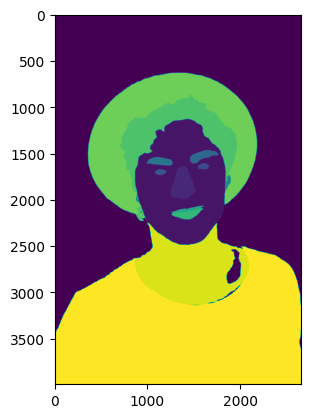

In [1]:
import torch
from torch import nn
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

from PIL import Image
import matplotlib.pyplot as plt
import requests

# convenience expression for automatically determining device
device = (
    "cuda"
    # Device for NVIDIA or AMD GPUs
    if torch.cuda.is_available()
    else "mps"
    # Device for Apple Silicon (Metal Performance Shaders)
    if torch.backends.mps.is_available()
    else "cpu"
)

# load models
image_processor = SegformerImageProcessor.from_pretrained("jonathandinu/face-parsing")
model = SegformerForSemanticSegmentation.from_pretrained("jonathandinu/face-parsing")
model.to(device)

# expects a PIL.Image or torch.Tensor
url = "https://images.unsplash.com/photo-1539571696357-5a69c17a67c6"
image = Image.open(requests.get(url, stream=True).raw)

# run inference on image
inputs = image_processor(images=image, return_tensors="pt").to(device)
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, ~height/4, ~width/4)

# resize output to match input image dimensions
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # H x W
                mode='bilinear',
                align_corners=False)

# get label masks
labels = upsampled_logits.argmax(dim=1)[0]

# move to CPU to visualize in matplotlib
labels_viz = labels.cpu().numpy()
plt.imshow(labels_viz)
plt.show()


In [2]:
labels.shape

torch.Size([3993, 2662])

In [7]:
parsing = labels.cpu().numpy()

In [25]:
import numpy as np

mask_image = np.zeros(parsing.shape)
mask_image[parsing==0] = 1.0
mask_image[parsing==18] = 1.0
mask_image[parsing==17] = 1.0




In [ ]:
# calculate segmentation area.

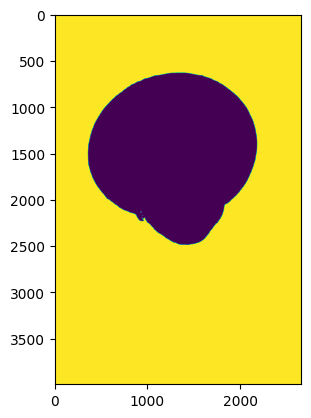

In [27]:
plt.imshow(mask_image)

In [ ]:
mask_image = 255 * (1 - mask_image)
mask_image = mask_image.astype(np.uint8)

In [1]:
!pip install super-image

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 3.4 MB/s eta 0:00:00
DEPRECATION: pytorch-lightning 1.6.5 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.dev0 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [1]:
from super_image import EdsrModel, ImageLoader
from PIL import Image
import requests

url = '/home/karan/kj_workspace/kj_ai/Professional-Headshot-with-single-image/backend/IP_akhil_result2.jpg'
image = Image.open(url)

model = EdsrModel.from_pretrained('eugenesiow/edsr-base', scale=2)
inputs = ImageLoader.load_image(image)
preds = model(inputs)

ImageLoader.save_image(preds, './scaled_2x.png')
ImageLoader.save_compare(inputs, preds, './scaled_2x_compare.png')

/home/karan/anaconda3/envs/python39/lib/python3.9/site-packages/huggingface_hub/file_download.py:655: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


https://huggingface.co/eugenesiow/edsr-base/resolve/main/pytorch_model_2x.pt


/home/karan/anaconda3/envs/python39/lib/python3.9/site-packages/super_image/data/loader.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.as_tensor([lr])


In [2]:
import numpy as np
from PIL import Image

In [3]:
import cv2

In [30]:
preds[0].max()

tensor(1.0167, device='cuda:0', grad_fn=<MaxBackward1>)

In [31]:
preds[0].min()

tensor(-0.0502, device='cuda:0', grad_fn=<MinBackward1>)

In [18]:
preds[0]

tensor([[[ 3.1636e-01,  3.1805e-01,  3.1830e-01,  ...,  2.9814e-01,
           3.0008e-01,  2.9584e-01],
         [ 3.1754e-01,  3.1834e-01,  3.1754e-01,  ...,  2.9836e-01,
           2.9898e-01,  2.9779e-01],
         [ 3.1817e-01,  3.1824e-01,  3.1694e-01,  ...,  2.9821e-01,
           2.9869e-01,  2.9949e-01],
         ...,
         [ 2.8385e-03,  2.5795e-03,  1.3491e-03,  ...,  1.1221e-02,
           1.1267e-02,  1.1092e-02],
         [ 2.0220e-03,  9.1477e-04, -1.8344e-04,  ...,  1.5754e-02,
           1.5468e-02,  1.4105e-02],
         [ 2.9686e-03, -1.7025e-05, -1.1830e-03,  ...,  1.7048e-02,
           1.5976e-02,  1.5479e-02]],

        [[ 3.3312e-01,  3.3548e-01,  3.3432e-01,  ...,  2.9864e-01,
           2.9900e-01,  2.9496e-01],
         [ 3.3358e-01,  3.3389e-01,  3.3294e-01,  ...,  2.9766e-01,
           2.9869e-01,  2.9685e-01],
         [ 3.3348e-01,  3.3369e-01,  3.3255e-01,  ...,  2.9781e-01,
           2.9833e-01,  2.9835e-01],
         ...,
         [ 2.2950e-03,  3

In [36]:
pred = preds.data.cpu().numpy()

#pred = pred[scale:-scale, scale:-scale, :]
#pred = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)

In [37]:
pred[0] = np.clip(pred[0], 0, 255)

In [38]:
pred = pred[0].transpose((1, 2, 0)) * 255

In [39]:
pred

array([[[80.67287   , 84.94438   , 83.62828   ],
        [81.103645  , 85.54828   , 84.14257   ],
        [81.16637   , 85.2519    , 84.099266  ],
        ...,
        [76.02687   , 76.153     , 74.077736  ],
        [76.519356  , 76.24528   , 74.21351   ],
        [75.43926   , 75.21531   , 73.25105   ]],

       [[80.97195   , 85.06416   , 83.89624   ],
        [81.17612   , 85.1424    , 84.2973    ],
        [80.97379   , 84.89917   , 84.15217   ],
        ...,
        [76.08265   , 75.90317   , 74.064674  ],
        [76.23987   , 76.16639   , 74.24903   ],
        [75.937355  , 75.697525  , 73.83661   ]],

       [[81.133316  , 85.03711   , 83.90051   ],
        [81.150154  , 85.09075   , 84.22093   ],
        [80.82092   , 84.79996   , 83.8723    ],
        ...,
        [76.042786  , 75.941246  , 73.98099   ],
        [76.16674   , 76.07299   , 74.03447   ],
        [76.370705  , 76.07913   , 74.2404    ]],

       ...,

       [[ 0.7238089 ,  0.585233  ,  7.973361  ],
        [ 0

In [40]:
pred = pred.astype(np.uint8)

In [41]:
pred.shape

(1024, 1024, 3)

In [42]:
pred.dtype

dtype('uint8')

In [43]:
import matplotlib.pyplot as plt

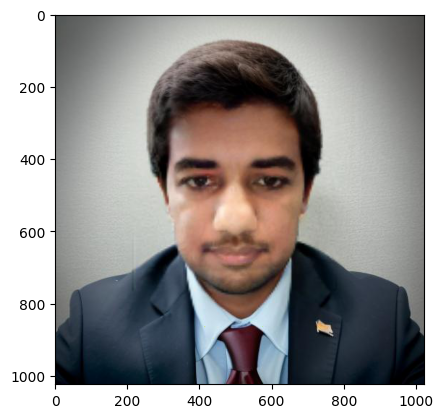

In [44]:
plt.imshow(pred)

In [16]:
result = Image.fromarray(pred)

In [17]:
result.save('exp.png')

In [100]:
from super_image import DrlnModel, ImageLoader
from PIL import Image
import requests

url = '/home/karan/kj_workspace/kj_ai/Professional-Headshot-with-single-image/backend/IP_akhil_result2.jpg'
image = Image.open(url)

model = DrlnModel.from_pretrained('eugenesiow/drln-bam', scale=2)      # scale 2, 3 and 4 models available
inputs = ImageLoader.load_image(image)
preds = model(inputs)

ImageLoader.save_image(preds, './scaled_2x.png')                        # save the output 2x scaled image to `./scaled_2x.png`
ImageLoader.save_compare(inputs, preds, './scaled_2x_compare.png')      # save an output comparing the super-image with a bicubic scaling


https://huggingface.co/eugenesiow/drln-bam/resolve/main/pytorch_model_2x.pt


: 